In [1]:
import os
import numpy as np
import scipy as sp
import robot_data_treatment
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy
from jupyterplot import ProgressPlot

## RoboCin Dataset

Below is a diagram of a roboCin SSL robot, where 4 wheels with their respective speeds ($[\omega_1,\omega_2,\omega_3,\omega_4]$) move the robot in order to create velocities $[v_x, v_y, \omega]$.

![robot dinamics](../imgs/robot_model2.png)

The wheel velocities can be translated into robot velocities using the following matrix transformation:

$$
    C = (1/r)\begin{bmatrix}
    -\sin{\theta_1} & \cos{\theta_1} & l \\
    -\sin{\theta_2} & \cos{\theta_2} & l \\
    -\sin{\theta_3} & \cos{\theta_3} & l \\
    -\sin{\theta_4} & \cos{\theta_4} & l \\
\end{bmatrix} 
$$

$$
\begin{bmatrix}
    v_x\\
    v_y\\
    \omega\\
\end{bmatrix} = C \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
\end{bmatrix}
$$

For our robot, $\theta_1 = \pi/3,\ \theta_2 = \pi-\pi/4,\ \theta_3 = \pi + \pi/4,\ \theta_4 = 2\pi-\pi/3,\ r = 0.025m,\ l = 0.083m $, where the $\theta$'s are the angles of each wheel relative to x-axis, $r$ is the radius of each wheel and $l$ is the distance between the wheels and the center of the robot.

A dataset was collected of different robots performing squared trajectories and logging a ground-truth pose (x, y, and angle coordinates) from an overhead camera, wheel speeds and timestamps of each measurement. A snippet of the collected data can be seen below.

As this is a transformation from 4 dimensions to 3 dimensions, the imprecision of each dimensions in the "wheel frame" is combined when translated to "robot frame". This model doesn't allow accurate tracking of the position of the robot in global frame of reference. Our goal is to verify if a data-driven approach can properly model the system dynamics in a way that a model-based estimation can't, as these errors are coming mostly from our poor definition of the model, so adding processes noises on a Kalman Filter (or the extended version) doesn't perform as well as intended.



,ID,ROBOT_X,ROBOT_Y,ROBOT_W,ROBOT_M1,ROBOT_M2,ROBOT_M3,ROBOT_M4,VISION_X,VISION_Y,VISION_W,BEHAVIOR,LABEL,TIMESTAMP,PCKT,CHANGE_STATE,GT_X,GT_Y,GT_THETA,GT_VX,GT_VY,GT_W
0,0,0.563,-2.490,1.6054,0.46,2.30,-1.38,-1.15,0.563227,-2.49075,1.58844,2,0,43918,146,NaN,0.000000,0.00000,1.58844,0.000000,0.000000,0.000000
1,0,0.563,-2.490,1.6054,1.61,1.15,-1.61,-1.38,0.563222,-2.49071,1.58844,2,0,43932,148,NaN,-0.000005,0.00004,1.58844,-0.000018,0.000143,0.000000
2,0,0.563,-2.489,1.6054,2.07,0.69,-1.15,-1.84,0.563162,-2.49063,1.58844,2,0,43943,150,NaN,-0.000065,0.00012,1.58844,-0.000291,0.000506,0.000000
3,0,0.563,-2.489,1.6054,1.38,1.38,-1.61,-2.30,0.563141,-2.49058,1.58844,2,0,43950,151,NaN,-0.000086,0.00017,1.58844,-0.000441,0.000864,0.000000
4,0,0.563,-2.488,1.6058,2.07,1.61,-2.07,-2.76,0.563599,-2.49025,1.59640,2,0,43961,153,NaN,0.000372,0.00050,1.59640,0.001641,0.002364,0.036182


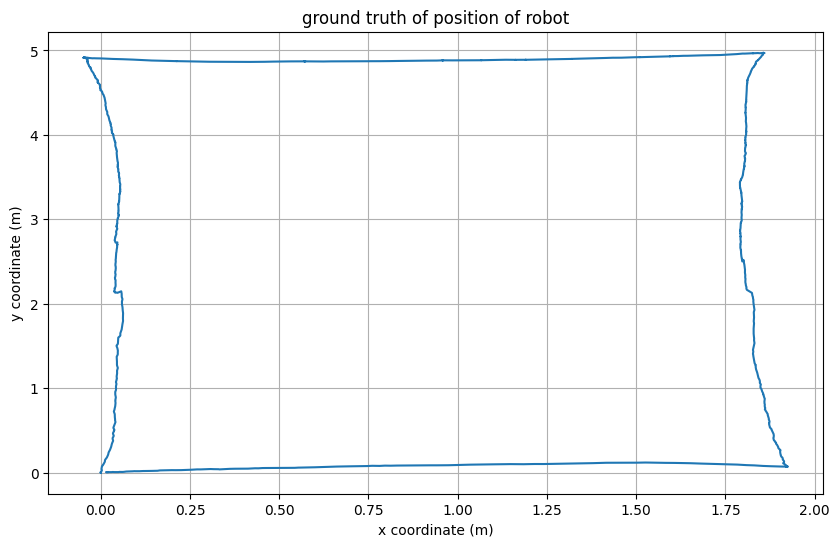

In [2]:
#data_generator = DataGenerator('dinos.txt')
data0, x0, y0 = robot_data_treatment.dataGet("../data/quadrado_opt_1_1.csv")
_, x1, y1 = robot_data_treatment.dataGet("../data/quadrado_opt_1_2.csv")
_, x2, y2 = robot_data_treatment.dataGet("../data/quadrado_opt_1_3.csv")
_, x3, y3 = robot_data_treatment.dataGet("../data/quadrado_opt_1_4.csv")
_, x4, y4 = robot_data_treatment.dataGet("../data/quadrado_opt_1_5.csv")
_, x5, y5 = robot_data_treatment.dataGet("../data/quadrado_opt_2_1.csv")
_, x6, y6 = robot_data_treatment.dataGet("../data/quadrado_opt_2_2.csv")
_, x7, y7 = robot_data_treatment.dataGet("../data/quadrado_opt_2_3.csv")
_, x8, y8 = robot_data_treatment.dataGet("../data/quadrado_opt_2_4.csv")
_, x9, y9 = robot_data_treatment.dataGet("../data/quadrado_opt_2_5.csv")

x0 = x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9
y0 = y0 + y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 + y9

sequenceLength = 10
trainTuple, valTuple, testTuple = robot_data_treatment.createTestTrainSets(x0, y0, sequenceLength, trainRatio=0.8, valRatio=0.1, testRatio=0.1)

display(HTML(data0.head(5).to_html()))

robot_data_treatment.dataPlotMulti([data0[' GT_X']], [data0[' GT_Y']], plotTitle="ground truth of position of robot")

## RNN Model

The model was kept close to [Kaggle's example](https://www.kaggle.com/code/fareselmenshawii/rnn-from-scratch) but with changes in relation to input/output dimensions, how the backpropagation and loss were calculated.

### inputs and outputs

Input of the model is now a sequence of the following vector:

$$
x_k = \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
    \theta\\
\end{bmatrix}_k
$$

While the output has the following format:
$$
y_k = 
\begin{bmatrix}
    v_x \\
    v_y \\
    \omega \\
\end{bmatrix}_k
$$

$y_k$ are the velocities in relation to a global reference frame, so the $\theta$ angle was added to the input vector as an expectation the system would learn to also perform the rotation matrix. $\theta$ is taken from the vision system, but the assumption here is that if we can provide the angle, can the robot have its own physical system modelled properly?

The sequence given to the model is a sequence of 10 timestamps, alongside their groundtruths.

### loss function and backpropagation

The new loss function can be defined as follows:

$$
L = \sum\limits_{i=0}^{N-1}{(\frac{1}{(N-i)}(\tilde{y}_i - gt_i)^2)}
$$

$$
Loss = L[0] + L[1] + L[2]
$$

This way, we weigh more the end of the sequence than the beginning. But also give equal importance to all three elements of the output vector

Consequently, the backpropagation is now:

$$

\frac{\partial{L}}{\partial{y_i}}_t = \frac{1}{(N-t)}(\tilde{y}_i - gt_{t,i})^2
$$


In [7]:
class RNN_robot:
    """
    A class used to represent a Recurrent Neural Network (RNN).

    Attributes
    ----------
    hidden_size : int
        The number of hidden units in the RNN.
    vocab_size : int
        The size of the vocabulary used by the RNN.
    sequence_length : int
        The length of the input sequences fed to the RNN.
    learning_rate : float
        The learning rate used during training.
    is_initialized : bool
        Indicates whether the AdamW parameters has been initialized.

    Methods
    -------
    __init__(hidden_size, vocab_size, sequence_length, learning_rate)
        Initializes an instance of the RNN class.

    forward(self, X, a_prev)
     Computes the forward pass of the RNN.

    softmax(self, x)
       Computes the softmax activation function for a given input array.

    backward(self,x, a, y_preds, targets)
        Implements the backward pass of the RNN.

   loss(self, y_preds, targets)
     Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

    adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4)
       Updates the RNN's parameters using the AdamW optimization algorithm.

    train(self, generated_names=5)
       Trains the RNN on a dataset using backpropagation through time (BPTT).

   predict(self, start)
        Generates a sequence of characters using the trained self, starting from the given start sequence.
        The generated sequence may contain a maximum of 50 characters or a newline character.

    """

    def __init__(self, trainSet, valSet, hidden_size, sequence_length, learning_rate):
        """
        Initializes an instance of the RNN class.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the RNN.
        vocab_size : int
            The size of the vocabulary used by the RNN.
        sequence_length : int
            The length of the input sequences fed to the RNN.
        learning_rate : float
            The learning rate used during training.
        """
        self.hidden_size = hidden_size
        self.trainSet = trainSet
        self.valSet = valSet

        # hyper parameters
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate
        self.X = None
        self.output_size = 3
        self.input_size = 5

        # model parameters
        BASE = 1
        self.Wax = BASE*np.random.uniform(-np.sqrt(1. / self.input_size), np.sqrt(1. / self.input_size), (hidden_size, self.input_size))
        self.Waa = BASE*np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (hidden_size, hidden_size))
        self.Wya = BASE*np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size), (self.output_size, hidden_size))
        self.ba = 0*BASE+np.zeros((hidden_size, 1))
        self.by = 0*BASE+np.zeros((self.output_size, 1))

        # Initialize gradients
        self.dWax, self.dWaa, self.dWya = 0*BASE+np.zeros_like(self.Wax), 0*BASE+np.zeros_like(self.Waa), 0*BASE+np.zeros_like(self.Wya)
        self.dba, self.dby = 0*BASE+np.zeros_like(self.ba), 0*BASE+np.zeros_like(self.by)

        # parameter update with AdamW
        self.mWax = 0*BASE+np.zeros_like(self.Wax)
        self.vWax = 0*BASE+np.zeros_like(self.Wax)
        self.mWaa = 0*BASE+np.zeros_like(self.Waa)
        self.vWaa = 0*BASE+np.zeros_like(self.Waa)
        self.mWya = 0*BASE+np.zeros_like(self.Wya)
        self.vWya = 0*BASE+np.zeros_like(self.Wya)
        self.mba = 0*BASE+np.zeros_like(self.ba)
        self.vba = 0*BASE+np.zeros_like(self.ba)
        self.mby = 0*BASE+np.zeros_like(self.by)
        self.vby = 0*BASE+np.zeros_like(self.by)

        self.pp = ProgressPlot(x_lim=[0, len(self.trainSet)])


    def softmax(self, x):
        """
        Computes the softmax activation function for a given input array.

        Parameters:
            x (ndarray): Input array.

        Returns:
            ndarray: Array of the same shape as `x`, containing the softmax activation values.
        """
        # shift the input to prevent overflow when computing the exponentials
        x = x - np.max(x)
        # compute the exponentials of the shifted input
        p = np.exp(x)
        # normalize the exponentials by dividing by their sum
        return p / np.sum(p)

    def forward(self, X, a_prev):
        """
        Compute the forward pass of the RNN.

        Parameters:
        X (ndarray): Input data of shape (seq_length, input_size)
        a_prev (ndarray): Activation of the previous time step of shape (hidden_size, 1)

        Returns:
        x (dict): Dictionary of input data of shape (seq_length, input_size, 1), with keys from 0 to seq_length-1
        a (dict): Dictionary of hidden activations for each time step, with keys from 0 to seq_length-1
        y_pred (dict): Dictionary of output global positions for each time step, with keys from 0 to seq_length-1
        """
        # Initialize dictionaries to store activations and output probabilities.
        x, a, y_pred = {}, {}, {}

        # Store the input data in the class variable for later use in the backward pass.
        self.X = X
        #print("input: ", self.X)
        # Set the initial activation to the previous activation.
        a[-1] = np.copy(a_prev)
        # iterate over each time step in the input sequence
        for t in range(len(self.X)):

            # get the input at the current time step
            x[t] = np.zeros((self.input_size,1))
            #if (self.X[t] != None):
            #    x[t][self.X[t]] = 1
            x[t] = np.array(X[t])
            x[t] = x[t].reshape((self.input_size,1))
            # compute the hidden activation at the current time step
#            print(f"{self.Wax.shape=}")
#            print(f"{x[t].shape=}")
#            print(f"{self.Waa.shape=}")
#            print(f"{a[t - 1].shape=}")
#            print(f"{self.ba.shape=}")
#            print("\n\n")
            a[t] = np.tanh(np.dot(self.Wax, x[t]) + np.dot(self.Waa, a[t - 1]) + self.ba)
            #print("a[t] shape:", a[t].shape)
            # compute the output probabilities at the current time step
            #print("self.Wya shape ", self.Wya.shape)
#            print(f"{a[t].shape=}")
#            print(f"{self.by.shape=}")
#            print(f"{self.Wya.shape=}")
#            y_pred[t] = self.softmax(np.dot(self.Wya, a[t]) + self.by)
            y_pred[t] = np.dot(self.Wya, a[t]) + self.by
#            print(f"{y_pred[t].shape=}")
            #print("y[t] shape ", y_pred[t].shape)
            # add an extra dimension to X to make it compatible with the shape of the input to the backward pass
        # return the input, hidden activations, and output probabilities at each time step
 #       print(f"{y_pred[0].shape=}")
        return x, a, y_pred

    def backward(self,x, a, y_preds, targets):
        """
        Implement the backward pass of the RNN.

        Args:
        x -- (dict) of input characters (as one-hot encoding vectors) for each time-step, shape (vocab_size, sequence_length)
        a -- (dict) of hidden state vectors for each time-step, shape (hidden_size, sequence_length)
        y_preds -- (dict) of output probability vectors (after softmax) for each time-step, shape (vocab_size, sequence_length)
        targets -- (list) of integer target characters (indices of characters in the vocabulary) for each time-step, shape (1, sequence_length)

        Returns:
        None

        """
        # Initialize derivative of hidden state for the last time-step
        da_next = np.zeros_like(a[0])

        # Loop through the input sequence backwards
        for t in reversed(range(len(self.X))):
            #print(t)
            #dy_preds[targets[t]](1/(len(self.X)-t))*np.square(y_preds[i] - targets[i])
            # Calculate derivative of output probability vector
            dy_preds = np.copy(y_preds[t])
            #for i in range(len(dy_preds)):
                #print(f"{y_preds[i]=}")
                #print(f"{targets[i]=}")
            #    dy_preds[i] = (1/(len(self.X)-t))*np.abs((y_preds[i][0] - targets[t][i]))
            #print(dy_preds)
            #print(len(dy_preds))
            #print(len(y_preds))
            #print(targets[t])
            #print("all targets")
            #print(targets)
            #for ()

            for index in range(len(dy_preds)):
                div = 1 #self.sequence_length-t
                dy_preds[index] = (2.0/(div))*(dy_preds[index] - targets[t][index])

            #dy_preds[targets[t]] -= 1

            # Calculate derivative of hidden state
            da = np.dot(self.Waa.T, da_next) + np.dot(self.Wya.T, dy_preds)
#            print(self.Waa.T.shape, da_next.shape)
#            print(self.Wya.T.shape, dy_preds.shape)
#            print("bbb")
            dtanh = (1 - np.power(a[t], 2))
#            print(self.dba.shape)
            da_unactivated = dtanh * da

            # Calculate gradients
            self.dba += da_unactivated
            self.dWax += np.dot(da_unactivated, x[t].T)
            self.dWaa += np.dot(da_unactivated, a[t - 1].T)

            # Update derivative of hidden state for the next iteration
            da_next = da_unactivated

            # Calculate gradient for output weight matrix
            self.dWya += np.dot(dy_preds, a[t].T)

            # clip gradients to avoid exploding gradients
            for grad in [self.dWax, self.dWaa, self.dWya, self.dba, self.dby]:
                np.clip(grad, -1, 1, out=grad)

    def loss(self, y_preds, targets):
        """
        Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

        Parameters:
            y_preds (ndarray): Array of shape (sequence_length, 1) containing the predicted velocities for each time step.
            targets (ndarray): Array of shape (sequence_length, 1) containing the true targets for each time step.

        Returns:
            float: Cross-entropy loss.
        """
        #print(y_preds)
        #print(targets)
        sum = 0
        for i in range(len(y_preds)):
            diff = y_preds[i] - targets[i].reshape((3,1))
            #print("aaaaaaaa ", diff)
            prod = np.dot(diff, diff.T)
            div = 1#1/(len(y_preds)-i)
            sum += np.sum((div)*prod)
        #print("\nsum ", sum)
        return sum

    def adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4):
        """
        Updates the RNN's parameters using the AdamW optimization algorithm.
        """
        # AdamW update for Wax
        self.mWax = beta1 * self.mWax + (1 - beta1) * self.dWax
        self.vWax = beta2 * self.vWax + (1 - beta2) * np.square(self.dWax)
        m_hat = self.mWax / (1 - beta1)
        v_hat = self.vWax / (1 - beta2)
        self.Wax -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wax)

        # AdamW update for Waa
        self.mWaa = beta1 * self.mWaa + (1 - beta1) * self.dWaa
        self.vWaa = beta2 * self.vWaa + (1 - beta2) * np.square(self.dWaa)
        m_hat = self.mWaa / (1 - beta1)
        v_hat = self.vWaa / (1 - beta2)
        self.Waa -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Waa)

        # AdamW update for Wya
        self.mWya = beta1 * self.mWya + (1 - beta1) * self.dWya
        self.vWya = beta2 * self.vWya + (1 - beta2) * np.square(self.dWya)
        m_hat = self.mWya / (1 - beta1)
        v_hat = self.vWya / (1 - beta2)
        self.Wya -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wya)

        # AdamW update for ba
        self.mba = beta1 * self.mba + (1 - beta1) * self.dba
        self.vba = beta2 * self.vba + (1 - beta2) * np.square(self.dba)
        m_hat = self.mba / (1 - beta1)
        v_hat = self.vba / (1 - beta2)
        self.ba -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.ba)

        # AdamW update for by
        self.mby = beta1 * self.mby + (1 - beta1) * self.dby
        self.vby = beta2 * self.vby + (1 - beta2) * np.square(self.dby)

    def train(self, generated_names=5):
        """
        Train the RNN on a dataset using backpropagation through time (BPTT).

        Args:
        - generated_names: an integer indicating how many example names to generate during training.

        Returns:
        - None
        """

        iter_num = 0
        threshold = 5 # stopping criterion for training
        smooth_loss = 100 #-np.log(1.0 / self.data_generator.vocab_size) * self.sequence_length  # initialize loss

        self.trainSet
        self.valSet
        self.losses = []
        self.smooth_losses = []
        while (iter_num < len(self.trainSet)):
            a_prev = np.zeros((self.hidden_size, 1))
            #idx = iter_num % self.vocab_size
            # get a batch of inputs and targets
            #inputs, targets = self.data_generator.generate_example(idx)
            inputs = self.trainSet[iter_num][0]
            #print("aaaaaaaa ", inputs)
            targets = self.trainSet[iter_num][1]

            # forward pass
            x, a, y_pred  = self.forward(inputs, a_prev)

            # backward pass
            self.backward(x, a, y_pred, targets)

            # calculate and update loss
            loss = self.loss(y_pred, targets)

            self.adamw()
            smooth_loss = smooth_loss * 0.999 + loss * 0.001
            self.smooth_losses.append(smooth_loss)
            self.losses.append(loss)

            self.pp.update(loss)

            # update previous hidden state for the next batch
            a_prev = a[len(self.X) - 1]
            # print progress every 500 iterations
            if iter_num % 25 == 0:
                print("iter :%d, loss:%f\n" % (iter_num, loss))
                #for i in range(generated_names):
                    #sample_idx = self.sample()
                    #txt = ''.join(self.data_generator.idx_to_char[idx] for idx in sample_idx)
                #    txt = txt.title()  # capitalize first character
                #    print ('%s' % (txt, ), end='')
            iter_num += 1
        self.pp.finalize()
        numberFilterCoefs = 15
        self.losses_filtered = scipy.signal.lfilter([1.0/numberFilterCoefs]*numberFilterCoefs, 1, self.losses)

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.losses_filtered)), self.losses_filtered)#, marker='o', linestyle='-')
        plt.title("loss")
        plt.xlabel("iter")
        plt.ylabel("loss")

        plt.grid(True)
        plt.show()

    def predict(self, start, num_sequences=1):
        """
        Generate a sequence of characters using the trained self, starting from the given start sequence.
        The generated sequence may contain a maximum of 50 characters or a newline character.

        Args:
        - start: a string containing the start sequence

        Returns:
        - txt: a string containing the generated sequence
        """

        # Initialize input vector and previous hidden state
        x = np.zeros((self.input_size, 1))
        x = start[0].reshape((self.input_size,1))
        a_prev = np.zeros((self.hidden_size, 1))

        y_preds = []
        # Generate sequence
        for counter in range(num_sequences):
            # Compute next hidden state and predicted character
            a = np.tanh(np.dot(self.Wax, x) + np.dot(self.Waa, a_prev) + self.ba)
            y_pred = self.softmax(np.dot(self.Wya, a) + self.by)
            y_preds.append(y_pred)

            # Update input vector, previous hidden state, and indices
            x = np.zeros((self.input_size, 1))
            x = start[counter].reshape((self.input_size,1))
            a_prev = a

        return y_preds

<IPython.core.display.Javascript object>

iter :0, loss:0.477551

iter :25, loss:2.384324

iter :50, loss:3.526185

iter :75, loss:0.241286

iter :100, loss:2.313830

iter :125, loss:0.404904

iter :150, loss:0.395869

iter :175, loss:8.852252

iter :200, loss:22.202579

iter :225, loss:8.266071

iter :250, loss:0.423040

iter :275, loss:3.936210

iter :300, loss:4.195998

iter :325, loss:15.794241

iter :350, loss:15.299628

iter :375, loss:121.888581

iter :400, loss:1.743257

iter :425, loss:8.944087

iter :450, loss:31.769460

iter :475, loss:0.193906

iter :500, loss:1.396191

iter :525, loss:15.761980

iter :550, loss:13.071607

iter :575, loss:9.463188

iter :600, loss:5.193666

iter :625, loss:7.885709

iter :650, loss:15.158516

iter :675, loss:4.059562

iter :700, loss:11.408091

iter :725, loss:0.353573

iter :750, loss:9.752407

iter :775, loss:1.936038

iter :800, loss:5.421641

iter :825, loss:0.008147

iter :850, loss:1.150940

iter :875, loss:70.171519

iter :900, loss:13.422991

iter :925, loss:7.850224

iter 

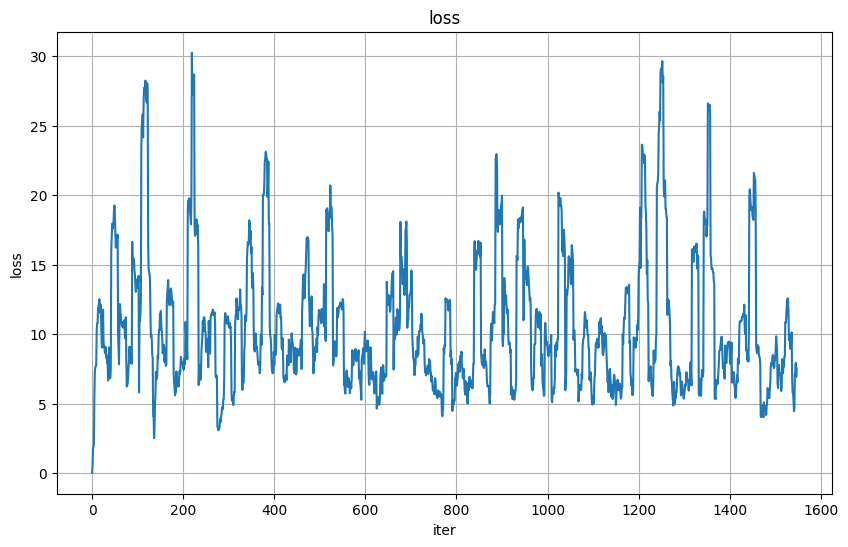

In [8]:
rnn = RNN_robot(trainTuple, valTuple, hidden_size=500, sequence_length=sequenceLength, learning_rate=1e-4)
rnn.train()

## Results after training

The loss function above doesn't converge, which could suggest that either we don't have enough training data, or our model is incomplete, with Fully Connected Layers for example, at the end, combining a big output vector of the RNN (size of hidden states), into the output size of 3. 

In [9]:
test = testTuple[14] # random input
input = test[0]
output = test[1]
for i in range(len(input)-1):
    est1, est2 = rnn.predict([input[i], input[i+1]], 2)
    gt1 = output[i].reshape(3,1)
    gt2 = output[i+1].reshape(3,1)
    diff1 = gt1 - est1
    diff2 = gt2 - est2
    print(diff1, diff2)

[[-0.05509633]
 [-0.3064016 ]
 [-0.27743262]] [[-0.0009332 ]
 [-0.29673441]
 [-0.34568357]]
[[-0.07635685]
 [-0.30169192]
 [-0.26530241]] [[-0.00832514]
 [-0.29530118]
 [-0.31454665]]
[[-0.02753502]
 [-0.32629099]
 [-0.26434696]] [[-0.01549399]
 [-0.31567859]
 [-0.29826054]]
[[-0.06052258]
 [-0.32605377]
 [-0.24285677]] [[-0.01818501]
 [-0.30861495]
 [-0.28318689]]
[[-0.05119733]
 [-0.32244476]
 [-0.23634476]] [[-0.02660107]
 [-0.30810325]
 [-0.2840492 ]]
[[-0.07359874]
 [-0.32322534]
 [-0.22192944]] [[-0.02686779]
 [-0.30120625]
 [-0.29169931]]
[[-0.09261495]
 [-0.30573632]
 [-0.22142209]] [[-0.05108052]
 [-0.29654241]
 [-0.29379328]]
[[-0.07916477]
 [-0.3102557 ]
 [-0.25199575]] [[-0.01805574]
 [-0.30111266]
 [-0.32978179]]
[[-0.06695711]
 [-0.31523518]
 [-0.26675791]] [[-0.0584584 ]
 [-0.31154755]
 [-0.32308239]]


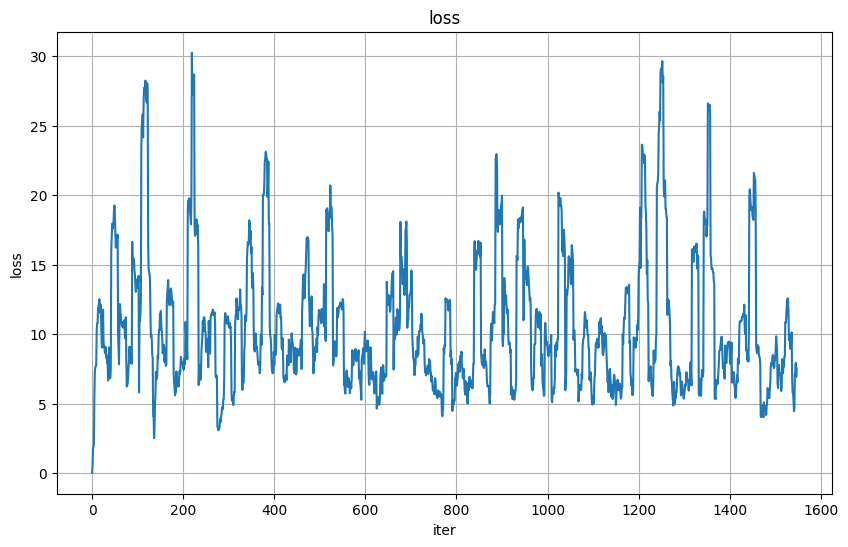

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(rnn.losses_filtered)), rnn.losses_filtered)#, marker='o', linestyle='-')
plt.title("loss")
plt.xlabel("iter")
plt.ylabel("loss")

plt.grid(True)
plt.show()